In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

### Config

In [18]:
cuda_available = torch.cuda.is_available()

print(f"CUDA disponible : {cuda_available}")

# Affiche également le nombre de GPU disponibles et leur nom si CUDA est disponible
if cuda_available:
    print(f"Nombre de GPU disponibles : {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("Aucun GPU n'est disponible. Entraînement sur CPU.")

CUDA disponible : True
Nombre de GPU disponibles : 1
GPU 0: NVIDIA GeForce GTX 1660 Ti


### Utils

In [3]:
def add_noise_to_labels(dataset, noise_level=0.1, num_classes=10):
    """
    Adds noise to the labels in the dataset.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to add noise to.
    noise_level (float): The fraction of labels to add noise to (between 0 and 1).
    num_classes (int): The number of classes in the dataset.

    Returns:
    torch.utils.data.Dataset: The dataset with noisy labels.
    """
    noisy_dataset = []
    for data, label in dataset:
        if random.random() < noise_level:
            # Randomly change the label to a different class
            new_label = random.randint(0, num_classes - 1)
            # Ensure new label is different from the original
            while new_label == label:
                new_label = random.randint(0, num_classes - 1)
            noisy_dataset.append((data, new_label))
        else:
            noisy_dataset.append((data, label))
    
    return noisy_dataset

### Data

In [4]:
# Load and normalize the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
noisy_train_set = add_noise_to_labels(trainset, noise_level=0.3)[:10000]
trainloader = torch.utils.data.DataLoader(noisy_train_set, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

### Model

In [5]:
# Define a two-layer dense neural network
class Net(nn.Module):
    def __init__(self, width=512):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, width)  # First layer (784 inputs, width outputs)
        self.fc2 = nn.Linear(width, 10)       # Second layer (width inputs, 10 outputs - one per digit)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def train(model):
    # Define a loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    # Train the network
    for epoch in range(10):  # Loop over the dataset multiple times
        running_loss = 0.0
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
    
            optimizer.zero_grad()  # Zero the parameter gradients
    
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()        # Backward pass
            optimizer.step()       # Optimize
    
            running_loss += loss.item()
            #if i % 100 == 99:    # Print every 100 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')

        # Put the model in evaluation mode
        model.eval()
        
        correct = 0
        total = 0
    
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                # If you're using GPU, move the data to the GPU
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate the accuracy
        accuracy = 100 * correct / total
        print(f'Accuracy of the model on the test images: {accuracy}%')
    
    print('Finished Training')
    return accuracy

### Double descent experiments

In [11]:
x_width = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

accuracy = []

for width in x_width:
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    accuracy.append(train(net))

Width : 2
Number of trainable parameters: 1600
[1,   157] loss: 2.340
Accuracy of the model on the test images: 17.42%
[2,   157] loss: 2.259
Accuracy of the model on the test images: 28.14%
[3,   157] loss: 2.168
Accuracy of the model on the test images: 32.98%
[4,   157] loss: 2.126
Accuracy of the model on the test images: 33.35%
[5,   157] loss: 2.101
Accuracy of the model on the test images: 34.21%
[6,   157] loss: 2.082
Accuracy of the model on the test images: 34.38%
[7,   157] loss: 2.067
Accuracy of the model on the test images: 34.54%
[8,   157] loss: 2.054
Accuracy of the model on the test images: 34.74%
[9,   157] loss: 2.043
Accuracy of the model on the test images: 32.84%
[10,   157] loss: 2.033
Accuracy of the model on the test images: 35.73%
Finished Training
Width : 4
Number of trainable parameters: 3190
[1,   157] loss: 2.298
Accuracy of the model on the test images: 27.29%
[2,   157] loss: 2.201
Accuracy of the model on the test images: 31.07%
[3,   157] loss: 2.143


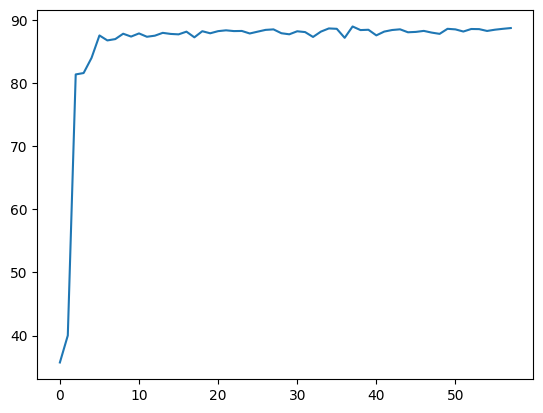

In [17]:
plt.plot(accuracy)

### Min-norm solution in deep model experiments

In [ ]:
# Step 1: Extract Features from the First Layer
model.eval()
with torch.no_grad():
    features = []
    for inputs, _ in data_loader:
        layer1_output = model.layer1(inputs)  # assuming 'layer1' is the first layer
        features.append(layer1_output)
    features = torch.cat(features, 0)

# Step 2: Get Weights of the Second Layer
weights_layer2 = model.layer2.weight.data  # assuming 'layer2' is the second layer
bias_layer2 = model.layer2.bias.data if model.layer2.bias is not None else 0

# Step 3: Calculate Min-Norm Solution for Linear Regression
# Assuming 'targets' is a tensor containing your target values
A_pinv = torch.pinverse(features)
min_norm_solution = torch.mm(A_pinv, targets)

# Step 4: Compare the Weights
# You can compare 'min_norm_solution' with 'weights_layer2' and 'bias_layer2'
# using your preferred method (e.g., Euclidean distance, cosine similarity)

# Example: Euclidean Distance
distance = torch.norm(min_norm_solution - weights_layer2 - bias_layer2)
print(f"Distance between the weights: {distance.item()}")